In [ ]:
import os
from tqdm import tqdm

from scipy.io import wavfile
# import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tkinter import *
# from tkinter import messagebox

# import librosa
# import librosa.util
from scipy.signal import find_peaks


def finish_box():
    window = Tk()
    window.geometry('250x150')
    window.title('Message')
    label = Label(window, text='실행 완료')
    label.pack(pady=30)
    window.mainloop()


def error_box(text='에러가 발생했습니다'):
    window = Tk()
    window.geometry('250x150')
    window.title('Error')
    label = Label(window, text=text)
    label.pack(pady=30)
    window.mainloop()


def dist_peaks(peaks, threshold=0.5):
    distances = np.diff(peaks)
    big_dist_idx = []
    for i, d in enumerate(distances):
        if d >= threshold:
            if i + 1 < len(peaks) / 2:
                big_dist_idx += [idx for idx in range(i + 1)]  # i+1까지 포함
            else:
                big_dist_idx += [idx for idx in range(i + 1, len(peaks))]
    #         elif d>0.3 and d<threshold and :

    #     big_dist = [d for d in distances if d>=threshold]
    #     big_dist_idx = [big_dist.index(d) for d in distances]

    return big_dist_idx


def detect_outliers(file_dir, threshold=0.1):
    ## file format error detection
    # 4) 파일 자체의 문제인 경우
    file = file_dir.split('/')[-1]
    try:
        sr, wav = wavfile.read(file_dir)
    except (UnboundLocalError, ValueError):
        return [file, 'FormatError']

    ## Outlier detection
    # 1) 데이터가 아예 없을 때(데이터 길이==0)
    if len(wav) == 0:
        wav = wav
        return [file, 'FormatError']
    # 2) 녹음이 제대로 안된 경우(데이터는 있음)
    # 2-1) 소리가 거의 없음
    elif np.abs(wav).max() <= 1000:
        return [file, 'Silence']
    # 2-2)

    wav = wav / np.abs(wav).max()
    sec = np.arange(len(wav)) / float(sr)
    length = len(wav) / float(sr)

    peaks, prop = find_peaks(wav, prominence=0.18, distance=90, height=0.12)
    peaks_sec = peaks / float(sr)
    outlier_idx = dist_peaks(peaks_sec)

    # 4) 앞뒤에 노이즈가 들어간 경우
    if len(outlier_idx) != 0:  # peak 중에 다른 peak와 간격이 너무 큰 peak(중앙 peak와 멀리 위치)
        outlier_heights = [prop['peak_heights'][i] for i in outlier_idx]
        max_outlier_h = max(outlier_heights)
        if max_outlier_h <= 0.2:
            return [file, 'Noise_low']
        else:
            return [file, 'Noise']

    # 3) 앞뒤 공백이 없는 경우
    for peak in peaks_sec:
        if peak <= 0.7 or peak >= length - 0.7:
            return [file, 'NoBlank']
    for (w, s) in zip(wav, sec):
        if s <= 0.7 and w > 0.2:
            return [file, 'NoBlank']
        elif s >= length - 0.7 and w > 0.2:
            return [file, 'NoBlank']

    return [file, 0]


def plot_audio_peaks(file_dir, save=False):
    file = file_dir.split('/')[-1]
    try:
        sr, wav = wavfile.read(file_dir)
    except (UnboundLocalError, ValueError):
        return [file, 'FormatError']

    wav = wav / np.abs(wav).max()
    sec = np.arange(len(wav)) / float(sr)
    length = len(wav) / float(sr)

    peaks, prop = find_peaks(wav, prominence=0.18, distance=90, height=0.12)
    peaks_sec = peaks / float(sr)

    plt.figure(figsize=(15, 3))
    plt.plot(sec, wav)
    plt.plot(peaks / float(sr), wav[peaks], "or", markersize=5)
    plt.tick_params(length=3, labelsize=14, labelcolor='white', top=True)
    plt.xlabel('Time(sec)', fontdict={'size': 20})
    plt.ylabel('Scailed Amplitude', fontdict={'size': 20})
    plt.title(file, fontdict={'size': 20})

    if save:
        if not os.path.isdir('issue_plots'):
            os.makedirs('issue_plots')
        plt.savefig('issue_plots/' + file + '.png')
    else:
        plt.show()




if os.path.isdir('data'):
    data_folders = os.listdir('data')
else:
    error_box('data 폴더가 없습니다')
    raise FileNotFoundError('No data folder')


pred = []
for folder in data_folders:
    file_list = os.listdir('data/'+folder)

    for file in tqdm(file_list):
        result = detect_outliers(f'data/{folder}/{file}')
        result.insert(1, folder)
        print(result)
        pred.append(result)

        if result[2] in ['Noise', 'Noise_low', 'NoBlank', 'Silence']:
            plot_audio_peaks(f'data/{folder}/{file}', save=True)

# DataFrame 형태로 생성
df_pred = pd.DataFrame(pred, columns=['file', 'folder', 'label'])

# csv 형태로 결과 저장
result_file = 'result.csv'
num = 1
while os.path.exists(result_file):
    result_file = f'result({num}).csv'
    num+=1
df_pred.to_csv(result_file, index=False)

finish_box()

In [36]:
import os
import shutil
from tqdm import tqdm

import IPython
from scipy.io import wavfile
import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from tkinter import *
from tkinter import messagebox

import librosa
import librosa.display
import librosa.util
from scipy.signal import find_peaks

In [2]:
SAMPLE_DIR = './../data/samples/'
TRAIN_DIR = './../data/train/'
TEST_DIR = './../data/test/'

if not os.path.isdir(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)
if not os.path.isdir(TEST_DIR):
    os.makedirs(TEST_DIR)

In [3]:
outliers = {'Noise' : ['de-DE_Bahner_F_10-50_Germany _Bixby_16.wav',
                       'de-DE_Bahner_F_10-50_Germany _Hi Bixby_4.wav',
                       'de-DE_Bahner_F_10-50_Germany _Hi Bixby_8.wav',
                       'de-DE_Bahner_F_10-50_Germany _Samsung Health_12.wav',
                       'de-DE_Bahner_F_10-50_Germany _Samsung Health_14.wav',
                       'de-DE_Becker _F_10-50_Germany_Hi Bixby_21.wav',
                       'de-DE_Christine_F_10-50_France_Hi Bixby_12.wav',
                       'de-DE_Christine_F_10-50_France_SmartThings.wav',
                       'de-DE_Klaus_M_10-50_Germany_Netflix_6.wav',
                       'de-DE_Klaus_M_10-50_Germany_Samsung Health_23.wav',
                       'de-DE_Klaus_M_10-50_Germany_Samsung Health_25.wav',
                       'de-DE_Christine_F_10-50_France_Hi Bixby_10.wav',
                       'de-DE_Christine_F_10-50_France_Bixby_27.wav',
                       'de-DE_Christine_F_10-50_France_Bixby_21.wav'
                      ],
            'NoBlank' : ['de-DE_Bahner_F_10-50_Germany _Hi SmartThings_10.wav',
                         'de-DE_Klaus_M_10-50_Germany_Hi Bixby_23.wav',
                         'de-DE_Klaus_M_10-50_Germany_Hi SmartThings_4.wav',
                        ],
            'Silence' : ['de-DE_Becker _F_10-50_Germany_YouTube_4.wav',
                        ],
            'FormatError' : ['de-DE_Christine_F_10-50_France_SmartThings_23.wav'
                                  ]
           }

In [4]:
# import pandas as pd

# file_list = os.listdir(TEST_DIR)
# lst = [[file, 0] for file in file_list]
# df_train = pd.DataFrame(lst, columns=['file', 'label'])
# for out in test_outliers['Noise']:
#     df_train.loc[df_train['file']==out, 'label'] = 'Noise'
# for out in outliers['NoBlank']:
#     df_train.loc[df_train['file']==out, 'label'] = 'NoBlank'
# for out in outliers['Silence']:
#     df_train.loc[df_train['file']==out, 'label'] = 'Silence'
# for out in outliers['FormatError']:
#     df_train.loc[df_train['file']==out, 'label'] = 'FormatError'
# df_train.to_csv('test.csv', index=False)

In [5]:
def plot_audio(wav_loc):
    try:
        sr, wav = wavfile.read(wav_loc)
    #     wav, sr = librosa.load(wav_loc,
    #                            sr=None
    #                           )
    except UnboundLocalError:
        return {'UnboundLocalError': wav_loc.split('/')[-1]}
    
    
    if len(wav)==0:
        wav = wav
        return {'Format Error': wav_loc.split('/')[-1]}
    elif np.abs(wav).max() <= 1000:
        print('Silence!', wav_loc.split('/')[-1])
        return {'Silence': wav_loc.split('/')[-1]}
    else:
        wav = wav / np.abs(wav).max()
    
    sec = np.arange(len(wav))/float(sr)
#     print(np.abs(wav).max())

    plt.figure(figsize=(20,6))
    plt.plot(sec, wav)
    plt.tick_params(length=3, labelsize=14, labelcolor='white', top=True)
    plt.xlabel('Time(sec)', fontdict={'color':'white', 'size':20})
    plt.ylabel('Scailed Amplitude', fontdict={'color':'white', 'size':20})
    plt.title(wav_loc.split('/')[-1], fontdict={'color':'white', 'size':20})
    plt.show()
    
    return None
    
#     IPython.display.Audio(data=wav, rate=sr)

In [6]:
# TRAIN_DIR = './../data/train/'

# train_files = os.listdir(TRAIN_DIR)

# outlier=[]
# for file in tqdm(train_files):
#     result = plot_audio(TRAIN_DIR + file)
#     if result != None:
#         outlier.append(result)
# #     sr, wav = wavfile.read(TRAIN_DIR + file)
# #     print(np.abs(wav).max())

In [61]:
def plot_audio_peaks(file_dir, save=False):
    file = file_dir.split('/')[-1]
    try:
        sr, wav = wavfile.read(file_dir)
    except (UnboundLocalError, ValueError):
        return [file, 'FormatError']
    
    wav = wav / np.abs(wav).max()
    sec = np.arange(len(wav)) / float(sr)
    length = len(wav) / float(sr)

    peaks, prop = find_peaks(wav, prominence=0.18, distance=90, height=0.12)
    peaks_sec = peaks / float(sr)

    plt.figure(figsize=(15,3))
    plt.plot(sec, wav)
    plt.plot(peaks/float(sr), wav[peaks], "or", markersize=5)
    plt.tick_params(length=3, labelsize=14, labelcolor='white', top=True)
    plt.xlabel('Time(sec)', fontdict={'color':'white', 'size':20})
    plt.ylabel('Scailed Amplitude', fontdict={'color':'white', 'size':20})
    plt.title(file, fontdict={'color':'white', 'size':20})
    
    if save:
        if not os.path.isdir('issue_plots'):
            os.makedirs('issue_plots')
        plt.savefig('issue_plots/'+file+'.png')
    else:
        plt.show()
    

## Noise


C:\Users\lynn1\AppData\Local\Temp\ipykernel_22232\3112693673.py:4: WavFileWarning: Reached EOF prematurely; finished at 387840 bytes, expected 387876 bytes from header.
  sr, wav = wavfile.read(file_dir)
C:\Users\lynn1\AppData\Local\Temp\ipykernel_22232\3112693673.py:4: WavFileWarning: Reached EOF prematurely; finished at 418560 bytes, expected 418596 bytes from header.
  sr, wav = wavfile.read(file_dir)
C:\Users\lynn1\AppData\Local\Temp\ipykernel_22232\3112693673.py:4: WavFileWarning: Reached EOF prematurely; finished at 533760 bytes, expected 533796 bytes from header.
  sr, wav = wavfile.read(file_dir)
C:\Users\lynn1\AppData\Local\Temp\ipykernel_22232\3112693673.py:4: WavFileWarning: Reached EOF prematurely; finished at 384000 bytes, expected 384036 bytes from header.
  sr, wav = wavfile.read(file_dir)
C:\Users\lynn1\AppData\Local\Temp\ipykernel_22232\3112693673.py:4: WavFileWarning: Reached EOF prematurely; finished at 449280 bytes, expected 449316 bytes from header.
  sr, wav = wav

## NoBlank


C:\Users\lynn1\AppData\Local\Temp\ipykernel_22232\3112693673.py:4: WavFileWarning: Reached EOF prematurely; finished at 360960 bytes, expected 360996 bytes from header.
  sr, wav = wavfile.read(file_dir)
C:\Users\lynn1\AppData\Local\Temp\ipykernel_22232\3112693673.py:4: WavFileWarning: Reached EOF prematurely; finished at 334080 bytes, expected 334116 bytes from header.
  sr, wav = wavfile.read(file_dir)


## Silence
## FormatError


C:\Users\lynn1\AppData\Local\Temp\ipykernel_22232\3112693673.py:4: WavFileWarning: Reached EOF prematurely; finished at 99840 bytes, expected 99876 bytes from header.
  sr, wav = wavfile.read(file_dir)


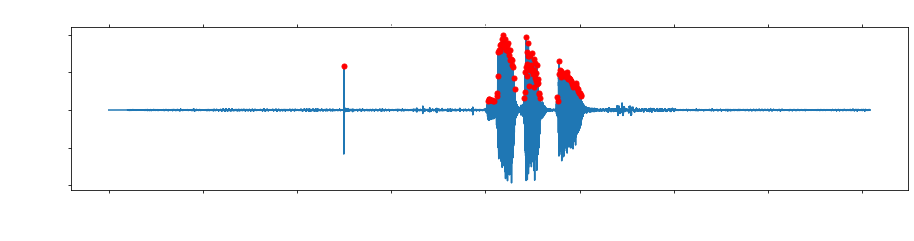

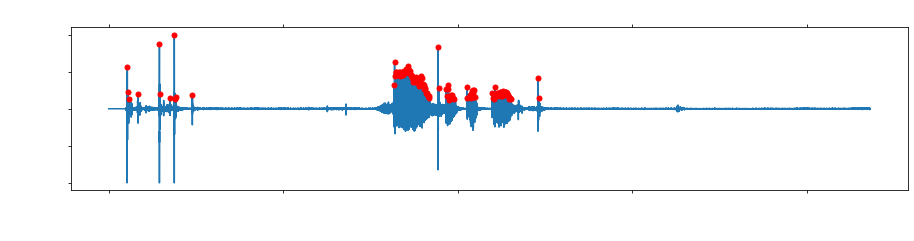

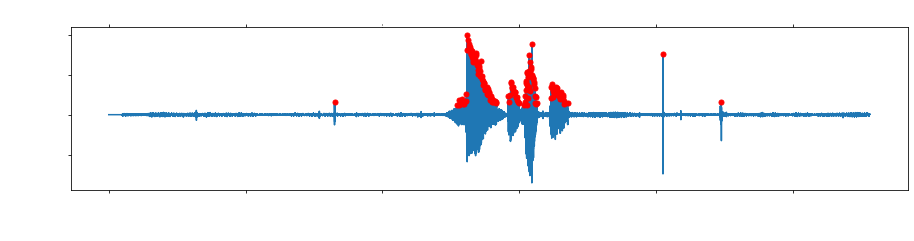

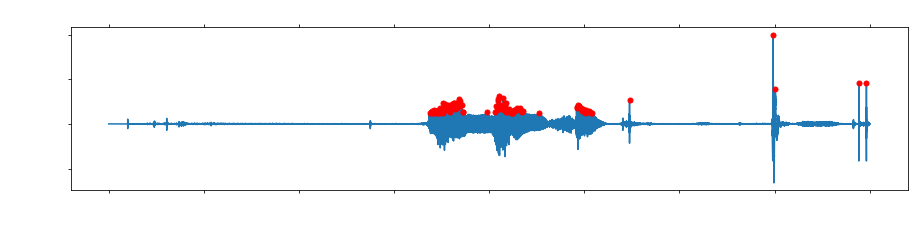

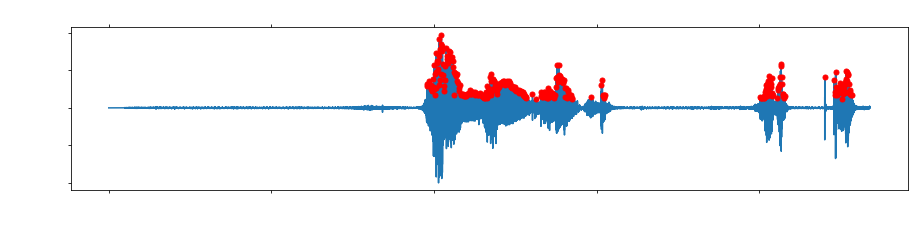

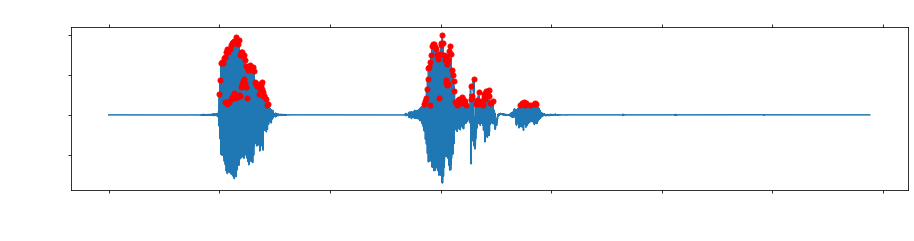

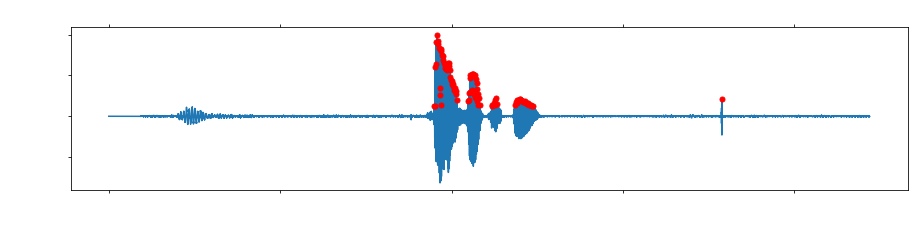

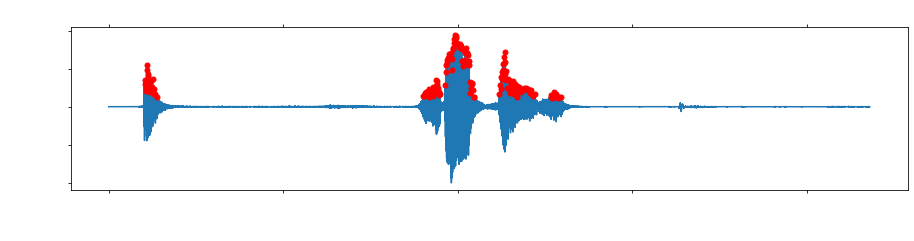

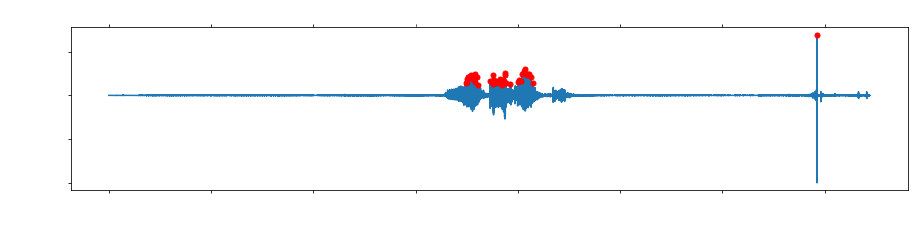

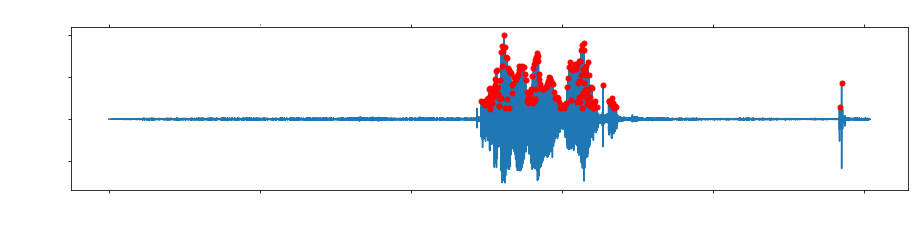

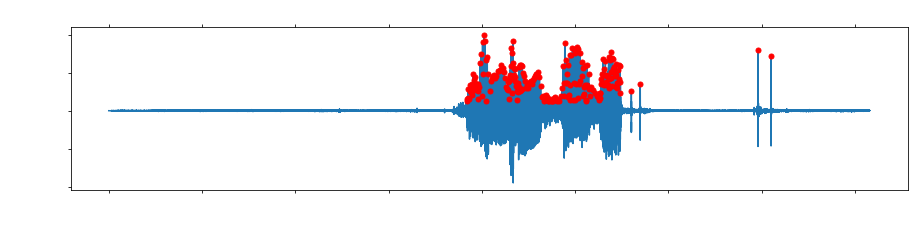

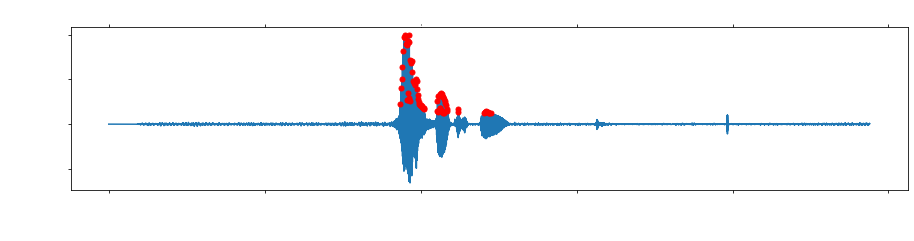

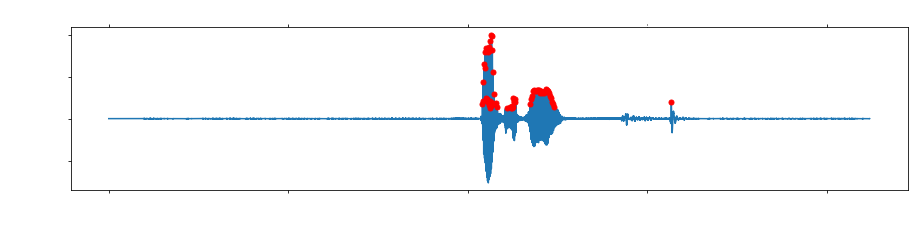

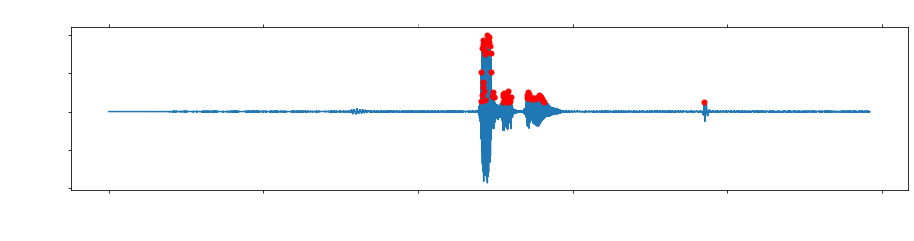

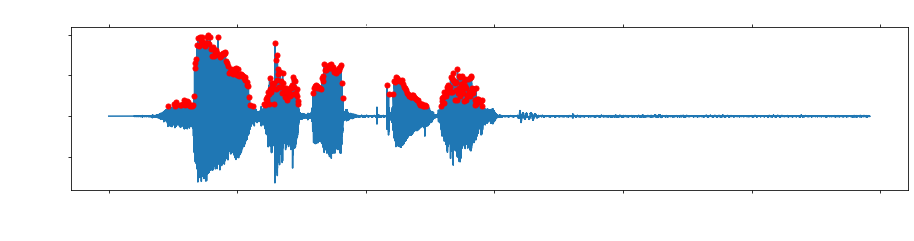

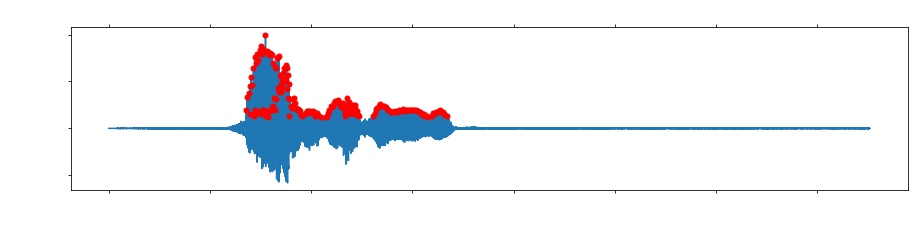

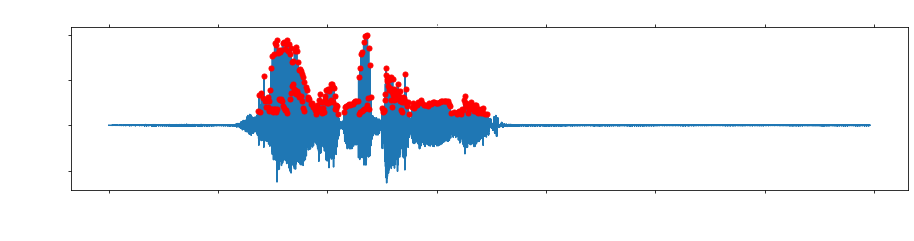

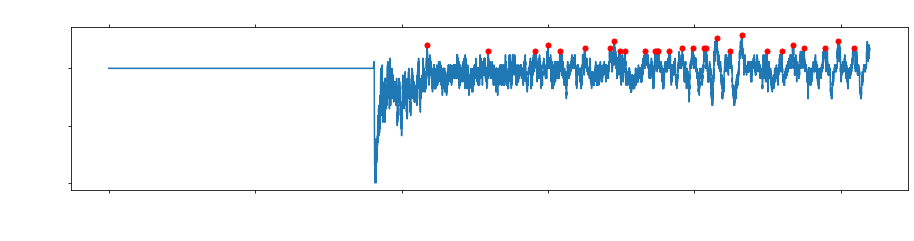

In [63]:
for category in outliers:
    print('##', category)
    for file in outliers[category]:
        plot_audio_peaks(TRAIN_DIR + file, save=False)

# Full Code

In [49]:
os.listdir('data')

['BAHNER, F', 'Becker, F', 'Chris, F', 'Klaus, M']

In [53]:
# current_py = sys.argv[0]
if os.path.isdir('data'):
    data_folders = os.listdir('data')
else:
    error_box('data 폴더가 없습니다')
    raise FileNotFoundError('No data folder')


for folder in data_folders:
    pass

In [8]:
file_list = os.listdir(TRAIN_DIR)

In [9]:
def dist_peaks(peaks, threshold=0.5):
    distances = np.diff(peaks)
    big_dist_idx = []
    for i, d in enumerate(distances):
        if d>=threshold:
            if i+1 < len(peaks)/2:
                big_dist_idx += [idx for idx in range(i+1)]  # i+1까지 포함
            else:
                big_dist_idx += [idx for idx in range(i+1, len(peaks))]
#         elif d>0.3 and d<threshold and :
            
#     big_dist = [d for d in distances if d>=threshold]
#     big_dist_idx = [big_dist.index(d) for d in distances]
    
    return big_dist_idx

In [10]:
def get_performance(df_pred, df_true):
    y_pred = [1 if label!=0 else 0 for label in df_pred['label']]
    y_true = [1 if label!=0 else 0 for label in df_true['label']]
    
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0,1])
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    
    return conf_matrix, acc

In [11]:
def detect_outliers(file_dir, threshold=0.1):
    ## file format error detection
    # 4) 파일 자체의 문제인 경우
    file = file_dir.split('/')[-1]
    try:
        sr, wav = wavfile.read(file_dir)
    except (UnboundLocalError, ValueError):
        return [file, 'FormatError']
    
    
    ## Outlier detection
    # 1) 데이터가 아예 없을 때(데이터 길이==0)
    if len(wav)==0:
        wav = wav
        return [file, 'FormatError']
    # 2) 녹음이 제대로 안된 경우(데이터는 있음)
    # 2-1) 소리가 거의 없음
    elif np.abs(wav).max() <= 1000:
        return [file, 'Silence']
    # 2-2) 
    
    
    wav = wav / np.abs(wav).max()
    sec = np.arange(len(wav))/float(sr)
    length = len(wav)/float(sr)

    peaks, prop = find_peaks(wav, prominence=0.18, distance=90, height=0.12)
    peaks_sec = peaks / float(sr)
    outlier_idx = dist_peaks(peaks_sec)
        
    # 4) 앞뒤에 노이즈가 들어간 경우
    if len(outlier_idx) != 0:   # peak 중에 다른 peak와 간격이 너무 큰 peak(중앙 peak와 멀리 위치)
        outlier_heights = [prop['peak_heights'][i] for i in outlier_idx]
        max_outlier_h = max(outlier_heights)
        if max_outlier_h <= 0.2:
            return [file, 'Noise_low']
        else:
            return [file, 'Noise']
    
    # 3) 앞뒤 공백이 없는 경우
    for peak in peaks_sec:
        if peak <= 0.7 or peak >= length-0.7:
            return [file, 'NoBlank']
    for (w, s) in zip(wav, sec):
        if s <= 0.7 and w > 0.2:
            return [file, 'NoBlank']
        elif s >= length-0.7 and w > 0.2:
            return [file, 'NoBlank']
        
    return [file, 0]

In [211]:
TRAIN_DIR = './../data/train/'
file_list = os.listdir(TRAIN_DIR)
# TEST_DIR = './../data/test/'
# file_list = os.listdir(TEST_DIR)

pred=[]

for file in tqdm(file_list):
    result = detect_outliers(TRAIN_DIR+file)
    pred.append(result)

df_pred = pd.DataFrame(pred, columns=['file', 'label'])
df_pred.to_csv('result_train3.csv', index=False)

  0%|                                                                                          | 0/480 [00:00<?, ?it/s]C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 376320 bytes, expected 376356 bytes from header.
  sr, wav = wavfile.read(file_dir)
C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 391680 bytes, expected 391716 bytes from header.
  sr, wav = wavfile.read(file_dir)
C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 345600 bytes, expected 345636 bytes from header.
  sr, wav = wavfile.read(file_dir)
  1%|▌                                                                                 | 3/480 [00:00<00:21, 22.35it/s]C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 380160 bytes, expected 380196 

 13%|██████████▋                                                                      | 63/480 [00:02<00:19, 21.93it/s]C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 337920 bytes, expected 337956 bytes from header.
  sr, wav = wavfile.read(file_dir)
 14%|███████████▋                                                                     | 69/480 [00:03<00:18, 22.57it/s]C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 341760 bytes, expected 341796 bytes from header.
  sr, wav = wavfile.read(file_dir)
 15%|████████████▏                                                                    | 72/480 [00:03<00:17, 22.93it/s]C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 334080 bytes, expected 334116 bytes from header.
  sr, wav = wavfile.read(file_dir)
 16%|████████████▋             

 60%|████████████████████████████████████████████████                                | 288/480 [00:12<00:08, 21.58it/s]C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 437760 bytes, expected 437796 bytes from header.
  sr, wav = wavfile.read(file_dir)
C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 552960 bytes, expected 552996 bytes from header.
  sr, wav = wavfile.read(file_dir)
 61%|█████████████████████████████████████████████████                               | 294/480 [00:12<00:09, 19.61it/s]C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1642305917.py:6: WavFileWarning: Reached EOF prematurely; finished at 487680 bytes, expected 487716 bytes from header.
  sr, wav = wavfile.read(file_dir)
100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [00:21<00:00, 22.46it/s]


In [47]:
def finish_box():
    window = Tk()
    window.geometry('200x100')
    window.title('Message')
    label = Label(window, text='실행 완료')
    label.pack(pady=30)
    window.mainloop()
    
def error_box(text='에러가 발생했습니다'):
    window=Tk()
    window.geometry('200x100')
    window.title('Error')
    label = Label(window, text=text)
    label.pack(pady=30)
    window.mainloop()

In [35]:
error_box()

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 387840 bytes, expected 387876 bytes from header.
  sr, wav = wavfile.read(wav_loc)


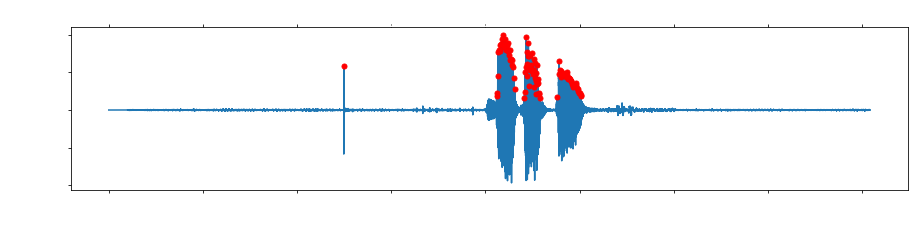

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 395520 bytes, expected 395556 bytes from header.
  sr, wav = wavfile.read(wav_loc)


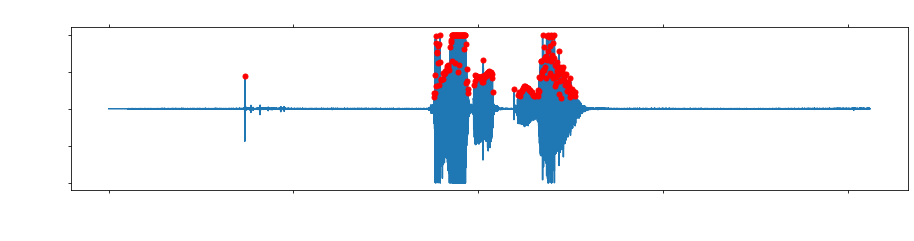

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 418560 bytes, expected 418596 bytes from header.
  sr, wav = wavfile.read(wav_loc)


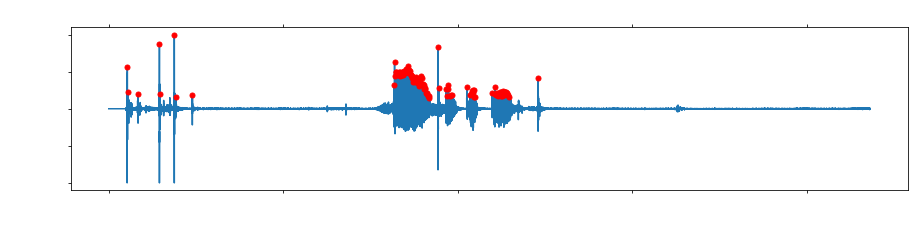

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 430080 bytes, expected 430116 bytes from header.
  sr, wav = wavfile.read(wav_loc)


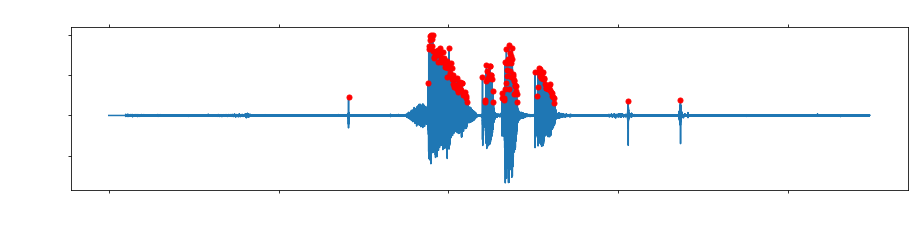

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 533760 bytes, expected 533796 bytes from header.
  sr, wav = wavfile.read(wav_loc)


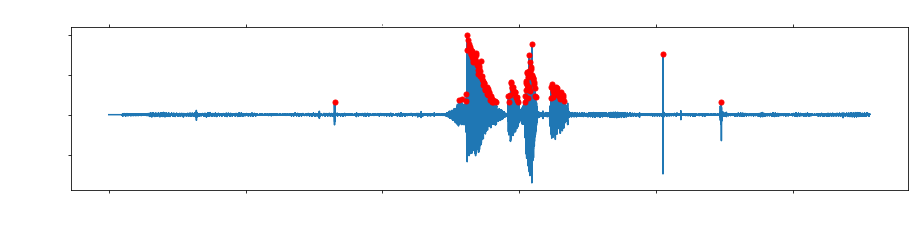

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 433920 bytes, expected 433956 bytes from header.
  sr, wav = wavfile.read(wav_loc)


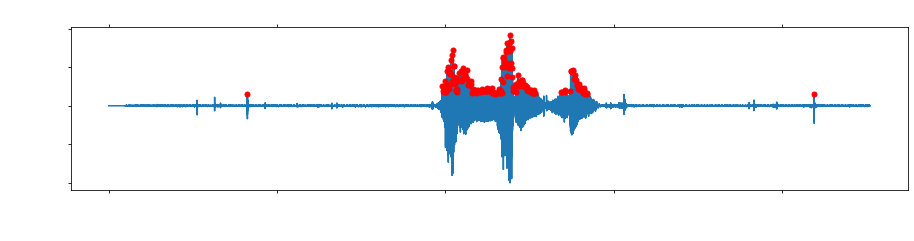

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 384000 bytes, expected 384036 bytes from header.
  sr, wav = wavfile.read(wav_loc)


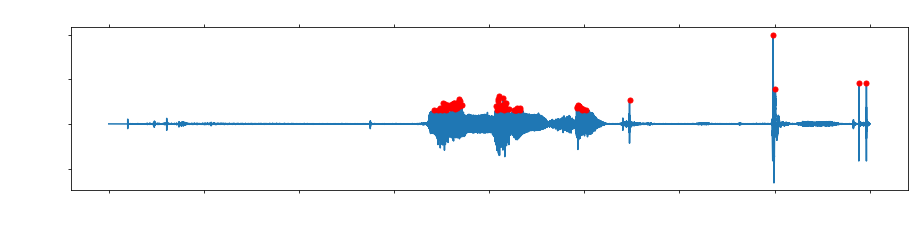

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 449280 bytes, expected 449316 bytes from header.
  sr, wav = wavfile.read(wav_loc)


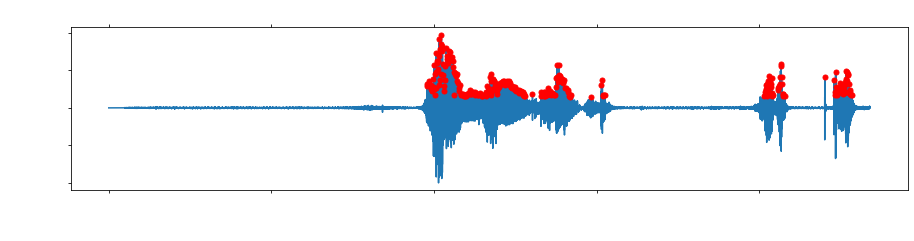

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 349440 bytes, expected 349476 bytes from header.
  sr, wav = wavfile.read(wav_loc)


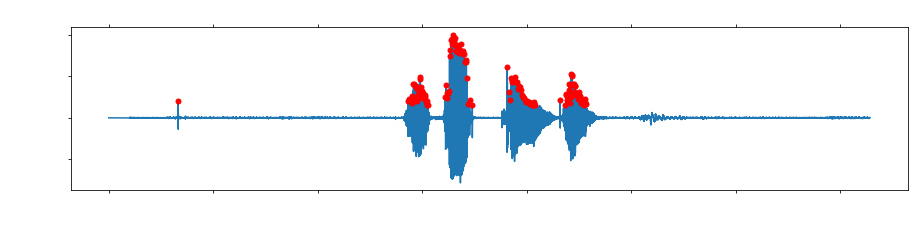

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 384000 bytes, expected 384036 bytes from header.
  sr, wav = wavfile.read(wav_loc)


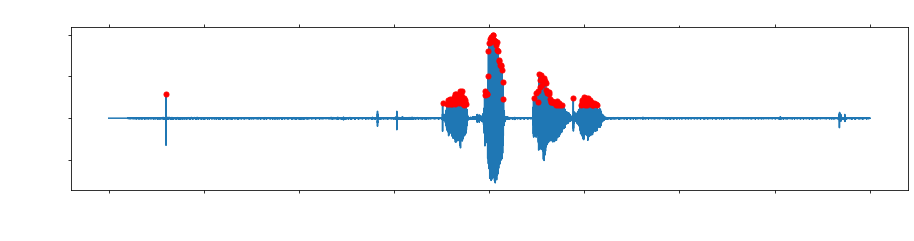

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 330240 bytes, expected 330276 bytes from header.
  sr, wav = wavfile.read(wav_loc)


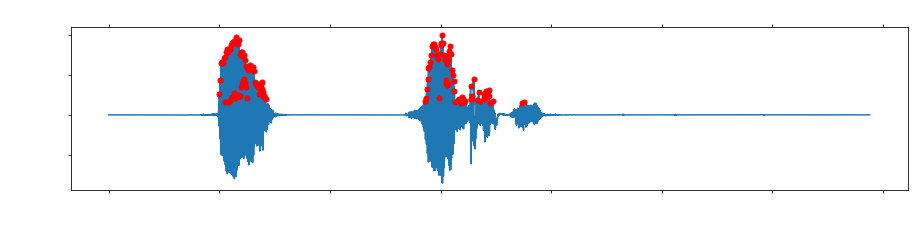

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 476160 bytes, expected 476196 bytes from header.
  sr, wav = wavfile.read(wav_loc)


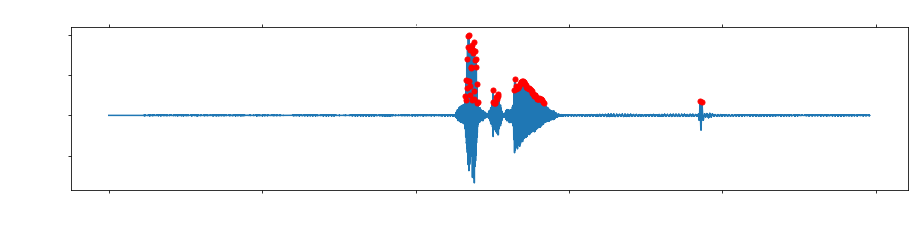

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 407040 bytes, expected 407076 bytes from header.
  sr, wav = wavfile.read(wav_loc)


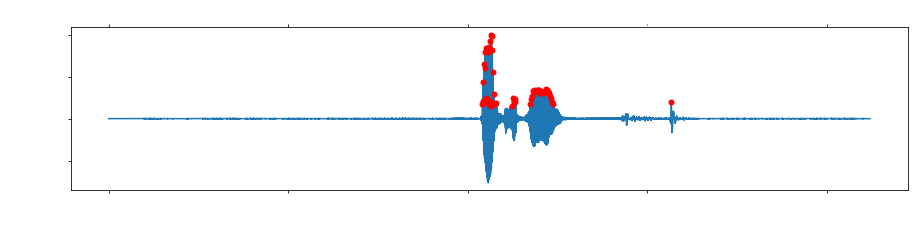

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 384000 bytes, expected 384036 bytes from header.
  sr, wav = wavfile.read(wav_loc)


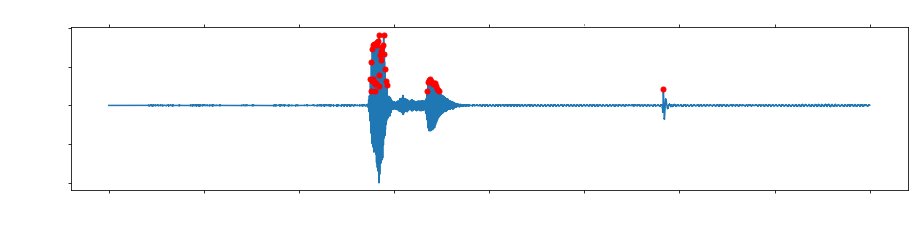

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 426240 bytes, expected 426276 bytes from header.
  sr, wav = wavfile.read(wav_loc)


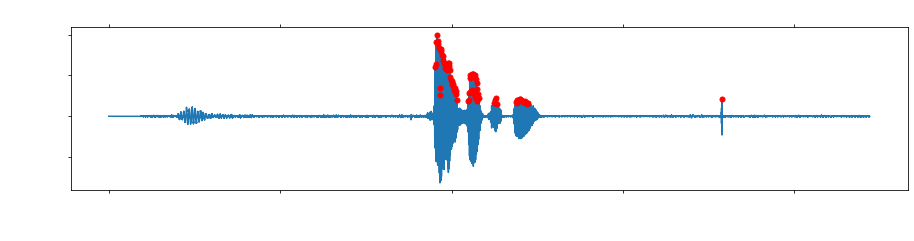

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 476160 bytes, expected 476196 bytes from header.
  sr, wav = wavfile.read(wav_loc)


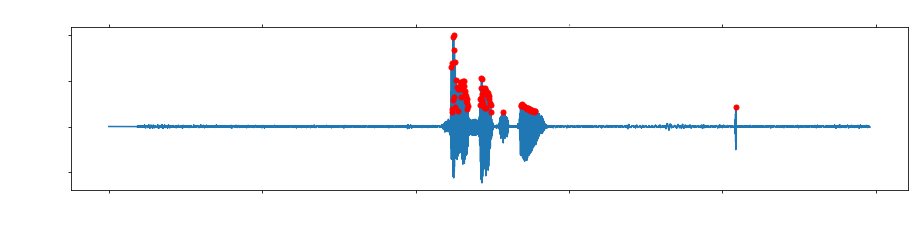

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 441600 bytes, expected 441636 bytes from header.
  sr, wav = wavfile.read(wav_loc)


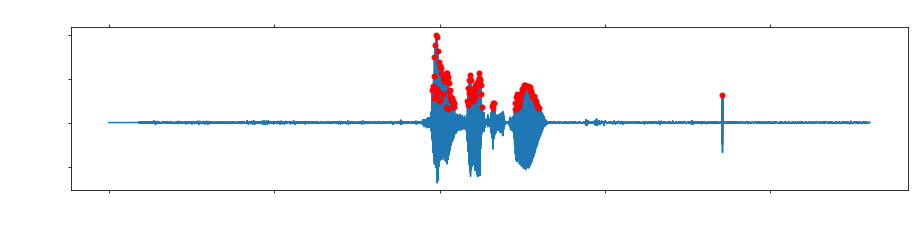

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 464640 bytes, expected 464676 bytes from header.
  sr, wav = wavfile.read(wav_loc)


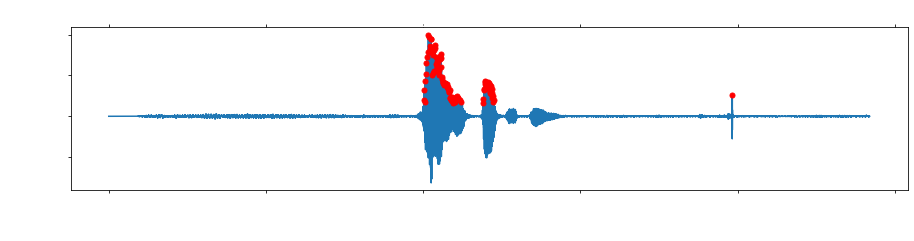

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 526080 bytes, expected 526116 bytes from header.
  sr, wav = wavfile.read(wav_loc)


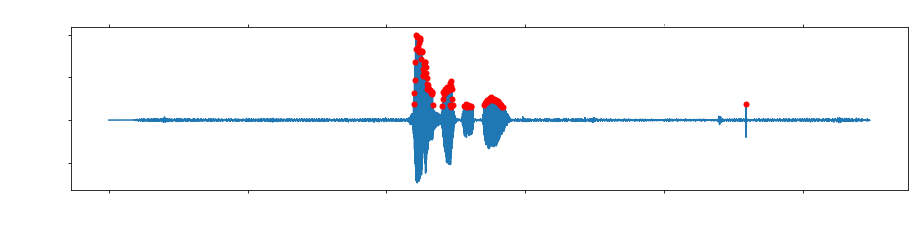

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 418560 bytes, expected 418596 bytes from header.
  sr, wav = wavfile.read(wav_loc)


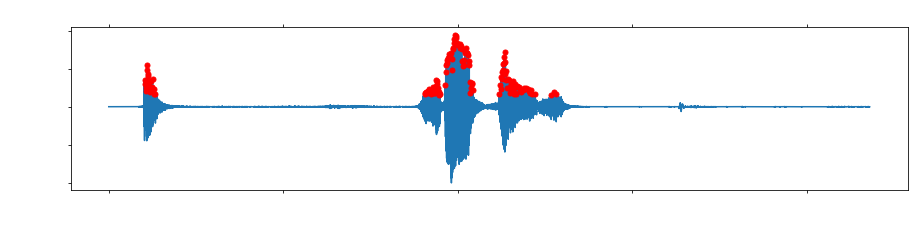

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 357120 bytes, expected 357156 bytes from header.
  sr, wav = wavfile.read(wav_loc)


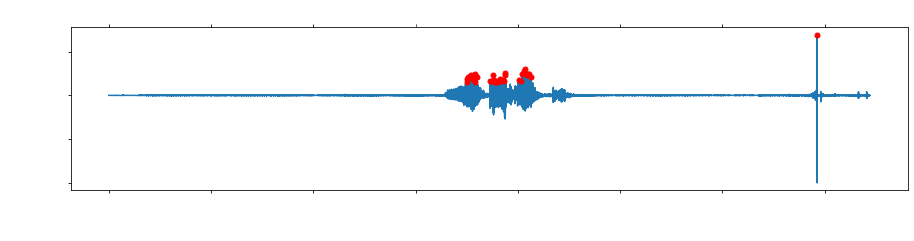

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 483840 bytes, expected 483876 bytes from header.
  sr, wav = wavfile.read(wav_loc)


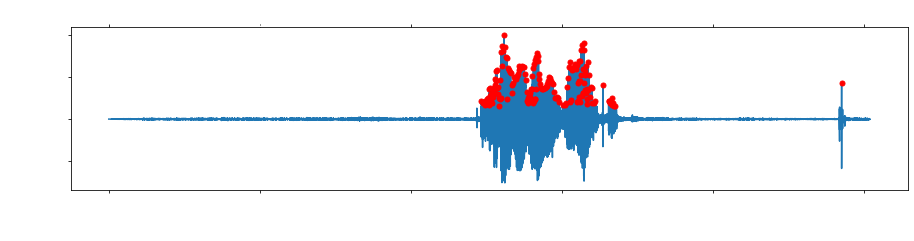

C:\Users\lynn1\AppData\Local\Temp\ipykernel_16664\1264702966.py:3: WavFileWarning: Reached EOF prematurely; finished at 391680 bytes, expected 391716 bytes from header.
  sr, wav = wavfile.read(wav_loc)


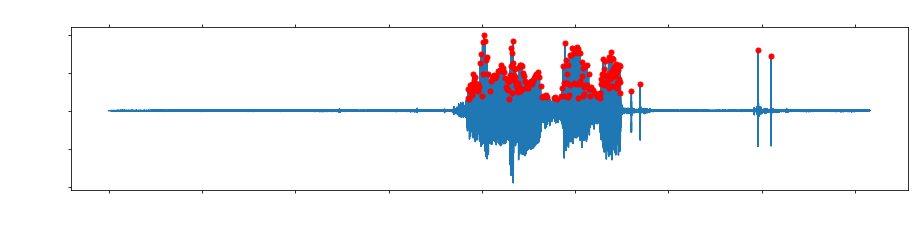

In [141]:
# Noise로 predict한 wav의 실제 peak 확인
for file in df_pred[df_pred['label']=='Noise'].file:
    plot_audio_peaks(TRAIN_DIR+file)
    plt.show()

In [146]:
outliers = {'Noise' : ['de-DE_Bahner_F_10-50_Germany _Bixby_16.wav',
                       'de-DE_Bahner_F_10-50_Germany _Disney Plus_14.wav',
                       'de-DE_Bahner_F_10-50_Germany _Hi Bixby_4.wav',
                       'de-DE_Bahner_F_10-50_Germany _Hi Bixby_6.wav',
                       'de-DE_Bahner_F_10-50_Germany _Hi Bixby_8.wav',
                       'de-DE_Bahner_F_10-50_Germany _Samsung Health_12.wav',
                       'de-DE_Bahner_F_10-50_Germany _Samsung Health_14.wav',
                       'de-DE_Becker _F_10-50_Germany_Hi Bixby_21.wav',
                       'de-DE_Christine_F_10-50_France_Hi Bixby_8.wav',
                       'de-DE_Christine_F_10-50_France_Hi Bixby_12.wav',
                       'de-DE_Christine_F_10-50_France_Hi Bixby_14.wav',
                       'de-DE_Christine_F_10-50_France_Hi Bixby_16.wav',
                       'de-DE_Christine_F_10-50_France_Hi Bixby_18.wav',
                       'de-DE_Christine_F_10-50_France_Hi Bixby_21.wav',
                       'de-DE_Christine_F_10-50_France_SmartThings.wav',
                       'de-DE_Christine_F_10-50_France_Bixby_4.wav',
                       'de-DE_Christine_F_10-50_France_Bixby_8.wav',
                       'de-DE_Christine_F_10-50_France_Bixby_18.wav',
                       'de-DE_Klaus_M_10-50_Germany_Netflix_6.wav',
                       'de-DE_Klaus_M_10-50_Germany_Samsung Health_23.wav',
                       'de-DE_Klaus_M_10-50_Germany_Samsung Health_25.wav',
                       'de-DE_Bahner_F_10-50_Germany _Disney Plus_14.wav',
                       'de-DE_Christine_F_10-50_France_Bixby_18.wav',
                       'de-DE_Christine_F_10-50_France_Bixby_4.wav',
                       'de-DE_Christine_F_10-50_France_Hi Bixby_14.wav'
                      ],
            'NoBlank' : ['de-DE_Bahner_F_10-50_Germany _Hi SmartThings_10.wav',
                         'de-DE_Klaus_M_10-50_Germany_Hi Bixby_23.wav',
                         'de-DE_Klaus_M_10-50_Germany_Hi SmartThings_4.wav',
                        ],
            'Silence' : ['de-DE_Becker _F_10-50_Germany_YouTube_4.wav',
                        ],
            'FormatError' : ['de-DE_Christine_F_10-50_France_SmartThings_23.wav'
                            ]
           }

In [159]:
test_outliers = {'Noise' : [
                            'de-DE_Bahner_F_10-50_Germany _Hi Bixby_13.wav',
                            'de-DE_Bahner_F_10-50_Germany _Hi Bixby_3.wav',
                            'de-DE_Bahner_F_10-50_Germany _Hi Bixby_5.wav',
#                             'de-DE_Bahner_F_10-50_Germany _Hi Bixby_7.wav',
#                             'de-DE_Bahner_F_10-50_Germany _Bixby_9.wav',
                            'de-DE_Bahner_F_10-50_Germany _Hi SmartThings_17.wav',
                            'de-DE_Bahner_F_10-50_Germany _Netflix_19.wav',
                            'de-DE_Bahner_F_10-50_Germany _Netflix_24.wav',
                            'de-DE_Bahner_F_10-50_Germany _Samsung Health_11.wav',
#                             'de-DE_Bahner_F_10-50_Germany _Samsung Health_22.wav',
                            'de-DE_Bahner_F_10-50_Germany _SmartThings_11.wav',
                            'de-DE_Bahner_F_10-50_Germany _SmartThings_19.wav',
                            'de-DE_Bahner_F_10-50_Germany _SmartThings_28.wav',
                            'de-DE_Christine_F_10-50_France_Bixby_11.wav',
                            'de-DE_Christine_F_10-50_France_Bixby_13.wav',
                            'de-DE_Christine_F_10-50_France_Bixby_19.wav',
#                             'de-DE_Christine_F_10-50_France_Bixby_22.wav',
                            'de-DE_Christine_F_10-50_France_Bixby_24.wav',
                            'de-DE_Christine_F_10-50_France_Bixby_26.wav',
                            'de-DE_Christine_F_10-50_France_Bixby_3.wav',
                            'de-DE_Christine_F_10-50_France_Bixby_5.wav',
                            'de-DE_Christine_F_10-50_France_Bixby_9.wav',
                            'de-DE_Christine_F_10-50_France_Hi Bixby_11.wav',
                            'de-DE_Christine_F_10-50_France_Hi Bixby_13.wav',
                            'de-DE_Christine_F_10-50_France_Hi Bixby_15.wav',
                            'de-DE_Christine_F_10-50_France_Hi Bixby_17.wav',
                            'de-DE_Christine_F_10-50_France_Hi Bixby_19.wav',
                            'de-DE_Christine_F_10-50_France_Hi Bixby_20.wav',
#                             'de-DE_Christine_F_10-50_France_Hi Bixby_28.wav',
                            'de-DE_Christine_F_10-50_France_Hi Bixby_7.wav',
                            'de-DE_Christine_F_10-50_France_Hi Bixby_9.wav',
#                             'de-DE_Christine_F_10-50_France_Samsung Health_3.wav',
#                             'de-DE_Klaus_M_10-50_Germany_Hi Bixby_1.wav',
#                             'de-DE_Klaus_M_10-50_Germany_Hi Bixby_28.wav',
#                             'de-DE_Klaus_M_10-50_Germany_Netflix_19.wav',
                            'de-DE_Klaus_M_10-50_Germany_Netflix_24.wav',
                            'de-DE_Klaus_M_10-50_Germany_Samsung Health_3.wav',
                           ],
                 'NoBlank' : ['de-DE_Bahner_F_10-50_Germany _Hi SmartThings_11.wav'
                              'de_DE_Klaus_M_10-50_Germany_Bixby_11.wav',
                             ],
                 'Silence' : [
                             ],
                 'FormatError' : ['de-DE_Christine_F_10-50_France_Netflix_15.wav',
                                  'de-DE_Christine_F_10-50_France_Netflix_3.wav',
                                  'de-DE_Christine_F_10-50_France_SmartThings_24.wav',
                                  'de-DE_Christine_F_10-50_France_SmartThings_26.wav'
                                 ]
                }